In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from poker_utils.constants import SUITS_DICT, HANDS_DICT, DECK_DICT, HANDS
from poker_utils.hands import normalize_hand
from sklearn.model_selection import train_test_split
from treys import Card, Evaluator
import random
from poker_utils.model import plot_train_loss
import torch.nn.functional as F

In [2]:
all_hands_df = pd.DataFrame(HANDS, columns=['card1','card2'])
all_hands_df['card1_treys'] = all_hands_df['card1'].apply(lambda x: Card.new(x))
all_hands_df['card2_treys'] = all_hands_df['card2'].apply(lambda x: Card.new(x))
all_hands_df['hands_norm'] = all_hands_df.apply(lambda x: normalize_hand((x['card1'],x['card2'])), axis=1)
all_hands_df['card1_id'] = all_hands_df['card1'].apply(lambda x: {j:i for i,j in DECK_DICT.items()}[x])
all_hands_df['card2_id'] = all_hands_df['card2'].apply(lambda x: {j:i for i,j in DECK_DICT.items()}[x])
all_hands_df['hands_norm_id'] = all_hands_df['hands_norm'].apply(lambda x: {j:i for i,j in HANDS_DICT.items()}[x])
all_hands_df['suit1_id']  = all_hands_df['card1_id'] % 4
all_hands_df['suit2_id']  = all_hands_df['card2_id'] % 4


In [3]:
all_hands_df.iloc[500]['card1_treys'].item()

270853

In [4]:
# [Card.new(x) for x in DECK_DICT.values()]

In [54]:
class HandStrengthDataset(Dataset):
    def __init__(self, all_hands_df, deck_dict, train=None):
        super().__init__()
        self.treys_mapper = {card_idx: Card.new(card_str) for card_idx, card_str in deck_dict.items()}
        self.evaluator = Evaluator()
        self.all_hands_df = all_hands_df.reset_index(drop=True)
        indexes = list(self.all_hands_df.index)
        self.deck = set(range(52))
        remain_cards = []
        for _, row in all_hands_df.iterrows():
            remaining = list(self.deck - {row['card1_id'], row['card2_id']})
            remain_cards.append(sorted(remaining))   
        self.remaining_cards = np.array(remain_cards, dtype=np.int64)
        
        if train is not None:
            train_indexes, val_indexes = train_test_split(indexes, test_size=0.2, random_state=29)
            if train:
                self.data = train_indexes
            else:
                self.data = val_indexes
        else:
            self.data = indexes
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        
        idx = self.data[item]
        row = self.all_hands_df.iloc[idx]
        hand_id = row['hands_norm_id']
        suit1_id = row['suit1_id']
        suit2_id = row['suit2_id']
        board_size = random.randint(3, 5)
        board = random.sample(list(self.remaining_cards[idx]), board_size)
        board_treys = [self.treys_mapper[x] for x in board]
        hand_treys = [row['card1_treys'].item(), row['card2_treys'].item()]
        try:
            strength = self.evaluator.evaluate(hand_treys, board_treys)
        except Exception as e:
            print(f"idx:{idx}")
            print(f"hand: {hand_treys}")
            print(f"board: {board_treys}")
            print(e)
        strength_norm = (7462 - strength) / 7461.0
        board += [-1] * (5 - board_size) # pad board
        return (
            torch.tensor(hand_id, dtype=torch.long),
            torch.tensor(suit1_id, dtype=torch.long),
            torch.tensor(suit2_id, dtype=torch.long),
            torch.tensor(board),
            torch.tensor(strength_norm, dtype=torch.float32)
        )
        


In [55]:
train_dataset = HandStrengthDataset(all_hands_df, deck_dict=DECK_DICT, train=True)
val_dataset = HandStrengthDataset(all_hands_df, deck_dict=DECK_DICT, train=False)
full_dataset = HandStrengthDataset(all_hands_df, deck_dict=DECK_DICT)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
fullloader = DataLoader(full_dataset, batch_size=128, shuffle=False)

In [71]:
class HandSuitEncoder(nn.Module):
    def __init__(self, preflop_embeddings, suit_dim=4, output_dim=16, freeze_hand_emb=True):
        super().__init__()
        self.suit_embedder = nn.Embedding(4, suit_dim)
        self.hand_embedder = nn.Embedding.from_pretrained(preflop_embeddings, freeze=freeze_hand_emb)
        self.model = nn.Sequential(
            nn.Linear(16 + suit_dim*2, 32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
        
    def forward(self, hand_id, suit1_id, suit2_id):
        preflop_emb = self.hand_embedder(hand_id)
        suit1_emb = self.suit_embedder(suit1_id)
        suit2_emb = self.suit_embedder(suit2_id)
        suit_vec = torch.cat([suit1_emb, suit2_emb], dim=1)
        x = torch.cat([preflop_emb, suit_vec], dim=1)
        return self.model(x)
    
        

In [72]:
class TransformerBoardEncoder(nn.Module):
    def __init__(self, card_dim=16, board_dim=32, num_heads=4, num_layers=2):
        super().__init__()

        self.card_embedder = nn.Embedding(52, card_dim)
        self.position_embedder = nn.Embedding(6, card_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, card_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=card_dim,
            nhead=num_heads,
            dim_feedforward=64,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(card_dim, board_dim)

    def forward(self, board_ids):
        """
        card_ids: [B, L] where L <= 5, -1 for padding
        """
        B, L = board_ids.shape

        mask = (board_ids != -1)
        safe_ids = board_ids.clone()
        safe_ids[~mask] = 0

        card_embs = self.card_embedder(safe_ids)

        cls_token = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_token, card_embs], dim=1)

        pos_ids = torch.arange(L + 1).unsqueeze(0).expand(B, L + 1)
        pos_embs = self.position_embedder(pos_ids)
        x = x + pos_embs

        pad_mask = torch.cat([torch.zeros(B, 1, dtype=torch.bool), ~mask], dim=1)

        out = self.transformer(x, src_key_padding_mask=pad_mask)

        cls_out = out[:, 0, :]
        return self.output_proj(cls_out) 

In [73]:
class HandStrengthPredictor(nn.Module):
    def __init__(self, suit_dim=4, hand_encoder_output_dim=16,
                 card_dim=16, board_dim=32, num_heads=4, num_layers=2, freeze_hand_emb=True):
        super().__init__()
        self.hand_encoder = HandSuitEncoder(
            torch.load("model_weights/preflop_embeddings.pt", weights_only=True).float(),
            suit_dim=suit_dim,
            output_dim=hand_encoder_output_dim,
            freeze_hand_emb=freeze_hand_emb
            )
        self.board_encoder = TransformerBoardEncoder(
            card_dim=card_dim, board_dim=board_dim, num_heads=num_heads, num_layers=num_layers
            )
        self.model = nn.Sequential(
            nn.Linear(hand_encoder_output_dim+board_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16,1)
        )
    
    def forward(self, hand_id, suit1_id, suit2_id, board_ids):
        hand_encoded = self.hand_encoder(hand_id, suit1_id, suit2_id)
        board_encoded = self.board_encoder(board_ids)
        x = torch.cat([hand_encoded, board_encoded], dim=1)
        return self.model(x)
    

In [83]:
def train_model(model, trainloader, valloader, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        tot_train_loss = 0
        model.train()
        for batch in trainloader:
            optimizer.zero_grad()
            hand_id, suit1_id, suit2_id, board, strength = batch
            strength_pred = model(hand_id,suit1_id, suit2_id, board)
            batch_loss = F.mse_loss(strength_pred, strength.unsqueeze(1))
            batch_loss.backward()
            optimizer.step()
            tot_train_loss += batch_loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
    
        model.eval()
        with torch.no_grad():
            tot_val_loss = 0
            for batch in valloader:
                hand_id, suit1_id, suit2_id, board, strength = batch
                strength_pred = model(hand_id,suit1_id, suit2_id, board)
                batch_loss = F.mse_loss(strength_pred, strength.unsqueeze(1))
                tot_train_loss += batch_loss.item()
            avg_val_loss = tot_train_loss / len(valloader)
            val_losses.append(avg_val_loss)
        
            if epoch % (epochs//5) == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
                
    return train_losses, val_losses

In [86]:
from itertools import product

In [ ]:
#{'suit_dim': 8, 
# 'hand_encoder_output_dim': 16, 
# 'card_dim': 64, 
# 'board_dim': 64, 
# 'num_heads': 4, 
# 'num_layers': 4}

In [91]:
model = HandStrengthPredictor(
        suit_dim=8,
        hand_encoder_output_dim=16,
        card_dim=64,
        board_dim=64,
        num_heads=4, 
        num_layers=4, 
        freeze_hand_emb=False
        )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
train_losses, val_losses = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        optimizer=optimizer,
        epochs=30
        )

Epoch 1/30, Train Loss: 0.1328, Val Loss: 0.4763
Epoch 7/30, Train Loss: 0.0508, Val Loss: 0.2022
Epoch 13/30, Train Loss: 0.0469, Val Loss: 0.1846
Epoch 19/30, Train Loss: 0.0461, Val Loss: 0.1846
Epoch 25/30, Train Loss: 0.0458, Val Loss: 0.2048


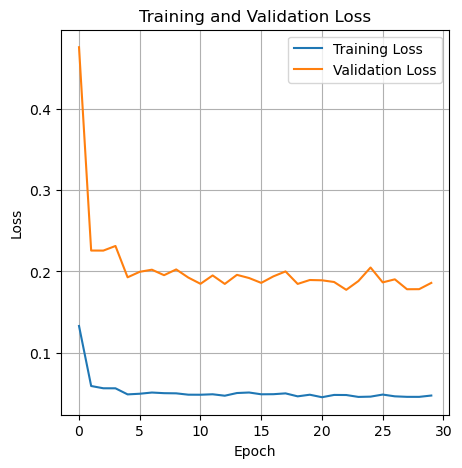

In [92]:
plot_train_loss(train_losses, val_losses)

In [87]:
param_grid = {
    "suit_dim": [4, 8, 16],
    "hand_encoder_output_dim": [16, 32],
    "card_dim": [16, 32, 64],
    "board_dim": [32, 64],
    "num_heads": [4, 8],
    "num_layers": [2, 4]
}
keys = list(param_grid.keys())
combinations = list(product(*[param_grid[k] for k in keys]))

In [ ]:
results = []
for combo in combinations:
    params = dict(zip(keys, combo))
    print(f"Testing: {params}")
    
    model = HandStrengthPredictor(
        suit_dim=params["suit_dim"],
        hand_encoder_output_dim=params["hand_encoder_output_dim"],
        card_dim=params["card_dim"],
        board_dim=params["board_dim"],
        num_heads=params["num_heads"], 
        num_layers=params["num_layers"], 
        freeze_hand_emb=False
        )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        optimizer=optimizer,
        epochs=30
        )
    results.append((params, train_losses[-1], val_losses[-1]))
